In [1]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from pymongo import MongoClient
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["research"]
performance_collection = db["performance-refactorings"]
non_performance_collection = db["non-performance-refactorings"]

In [3]:
# Fetch data from MongoDB
performance_data = list(performance_collection.find({}, {"_id": 0, "type": 1, "commit_id": 1}))
non_performance_data = list(
    non_performance_collection.find({}, {"_id": 0, "type": 1, "commit_id": 1})
)

print(performance_data)

[{'type': 'Move Class', 'commit_id': '31471acb69bb5e41d0668cfbf10c3d8e083b1861'}, {'type': 'Move Class', 'commit_id': '31471acb69bb5e41d0668cfbf10c3d8e083b1861'}, {'type': 'Move Class', 'commit_id': '31471acb69bb5e41d0668cfbf10c3d8e083b1861'}, {'type': 'Change Class Access Modifier', 'commit_id': '31471acb69bb5e41d0668cfbf10c3d8e083b1861'}, {'type': 'Change Method Access Modifier', 'commit_id': '31471acb69bb5e41d0668cfbf10c3d8e083b1861'}, {'type': 'Change Class Access Modifier', 'commit_id': '31471acb69bb5e41d0668cfbf10c3d8e083b1861'}, {'type': 'Rename Method', 'commit_id': '31471acb69bb5e41d0668cfbf10c3d8e083b1861'}, {'type': 'Change Method Access Modifier', 'commit_id': '31471acb69bb5e41d0668cfbf10c3d8e083b1861'}, {'type': 'Change Class Access Modifier', 'commit_id': '31471acb69bb5e41d0668cfbf10c3d8e083b1861'}, {'type': 'Rename Method', 'commit_id': '31471acb69bb5e41d0668cfbf10c3d8e083b1861'}, {'type': 'Change Method Access Modifier', 'commit_id': '31471acb69bb5e41d0668cfbf10c3d8e083

In [4]:
# Convert MongoDB documents to DataFrame
performance_df = pd.DataFrame(performance_data)
non_performance_df = pd.DataFrame(non_performance_data)

print(performance_df.head())

                            type                                 commit_id
0                     Move Class  31471acb69bb5e41d0668cfbf10c3d8e083b1861
1                     Move Class  31471acb69bb5e41d0668cfbf10c3d8e083b1861
2                     Move Class  31471acb69bb5e41d0668cfbf10c3d8e083b1861
3   Change Class Access Modifier  31471acb69bb5e41d0668cfbf10c3d8e083b1861
4  Change Method Access Modifier  31471acb69bb5e41d0668cfbf10c3d8e083b1861


In [5]:
# Combine the data for analysis
combined_df = pd.concat([performance_df, non_performance_df], ignore_index=True)

Frequent Itemset and Association Rules For General Refactorings

In [6]:
# Create a basket format for the Apriori algorithm
# Assuming 'type' as the item for association rule mining
basket = (
    combined_df.groupby(["commit_id", "type"])["type"]
    .count()
    .unstack()
    .reset_index()
    .fillna(0)
    .set_index("commit_id")
)
basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)

In [7]:
# Generate frequent itemsets
frequent_itemsets = apriori(basket_sets, min_support=0.03, use_colnames=True)



print(frequent_itemsets)

/Users/nanaquam/.pyenv/versions/3.11.0/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


      support                                           itemsets
0    0.050166                           (Add Attribute Modifier)
1    0.040645                             (Add Class Annotation)
2    0.097814                            (Add Method Annotation)
3    0.033846                              (Add Method Modifier)
4    0.177072                                    (Add Parameter)
..        ...                                                ...
98   0.033050  (Change Variable Type, Change Return Type, Ren...
99   0.035206  (Rename Variable, Change Return Type, Change V...
100  0.032416  (Rename Variable, Rename Method, Change Variab...
101  0.030401  (Rename Variable, Rename Parameter, Change Var...
102  0.034077  (Change Variable Type, Change Return Type, Cha...

[103 rows x 2 columns]


In [8]:
# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
print(rules)

                                        antecedents  \
0                   (Change Method Access Modifier)   
1                           (Change Parameter Type)   
2                              (Change Return Type)   
3                                (Remove Parameter)   
4                                (Rename Parameter)   
..                                              ...   
115   (Change Variable Type, Change Parameter Type)   
116   (Change Variable Type, Change Attribute Type)   
117     (Change Return Type, Change Parameter Type)   
118     (Change Return Type, Change Attribute Type)   
119  (Change Attribute Type, Change Parameter Type)   

                                       consequents  antecedent support  \
0                                  (Add Parameter)            0.111965   
1                                  (Add Parameter)            0.130528   
2                                  (Add Parameter)            0.133269   
3                                  (Add Par

In [9]:
# If you want to save the results to a CSV file
frequent_itemsets.sort_values(by="support", ascending=False).to_csv(
    "general_refactorings_frequent_itemsets.csv", index=False
)
# frequent_itemsets.to_csv("frequent_itemsets.csv", index=False)
rules.sort_values(by="confidence", ascending=False).to_csv(
    "general_refactorings_association_rules.csv", index=False
)

/var/folders/c7/8b2s2mnn2dndkrh3sh9_2kym0000gn/T/ipykernel_5898/1352127791.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/Users/nanaquam/.pyenv/versions/3.11.0/lib/python3.11/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/nanaquam/.pyenv/versions/3.11.0/lib/python3.11/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  comm

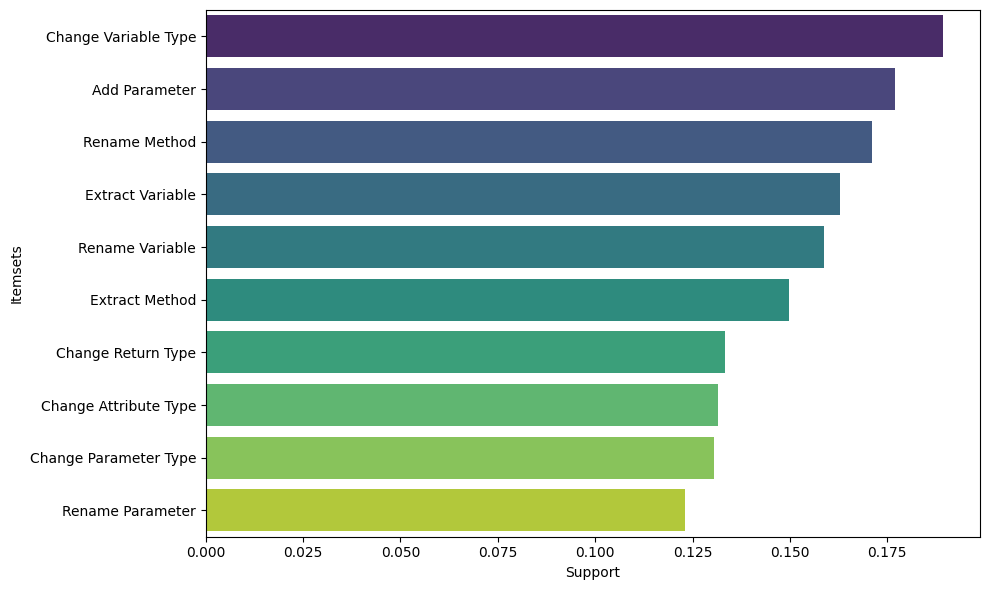

In [10]:
# Visualization of Frequent Itemsets
frequent_itemsets_plot = frequent_itemsets.sort_values(
    by="support", ascending=False
).head(10)

# Modified line to remove 'frozenset()' and extract contents
frequent_itemsets_plot["itemsets"] = frequent_itemsets_plot["itemsets"].apply(
    lambda x: ", ".join(list(x)).replace("'", "")
)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="support",
    y="itemsets",
    data=frequent_itemsets_plot,  # Use the modified dataframe
    palette="viridis",
)
plt.title("")
plt.xlabel("Support")
plt.ylabel("Itemsets")
plt.tight_layout()  # Added to prevent label cutoff
plt.show()

/Users/nanaquam/.pyenv/versions/3.11.0/lib/python3.11/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/nanaquam/.pyenv/versions/3.11.0/lib/python3.11/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


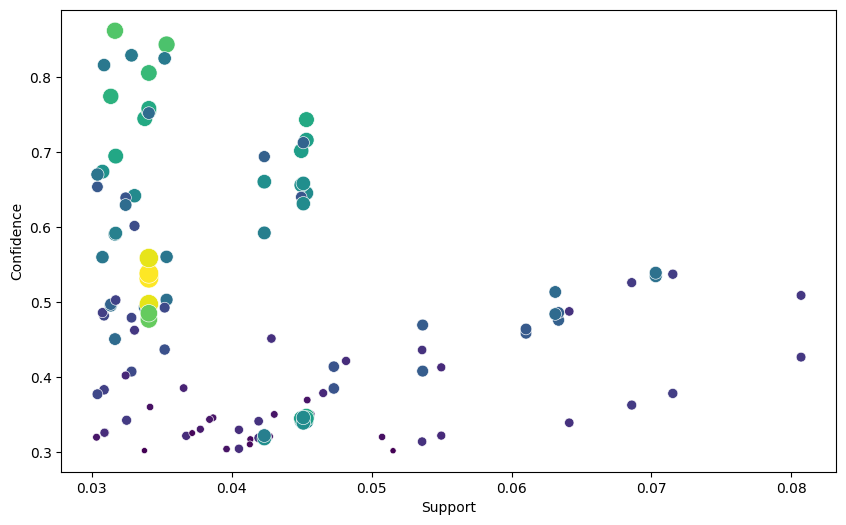

In [11]:
# Visualization of Association Rules
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="support",
    y="confidence",
    size="lift",
    data=rules,
    hue="lift",
    palette="viridis",
    legend=False,
    sizes=(20, 200),
)
plt.title("")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.show()

Frequent Itemset and Association Rules For Performance Refactorings

In [12]:
# Create a basket format for the Apriori algorithm
# Assuming 'type' as the item for association rule mining
basket = (
    performance_df.groupby(["commit_id", "type"])["type"]
    .count()
    .unstack()
    .reset_index()
    .fillna(0)
    .set_index("commit_id")
)
basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)

In [13]:
# Generate frequent itemsets
frequent_itemsets = apriori(basket_sets, min_support=0.03, use_colnames=True)
print(frequent_itemsets)

     support                                           itemsets
0   0.060881                           (Add Attribute Modifier)
1   0.034974                             (Add Class Annotation)
2   0.082470                            (Add Method Annotation)
3   0.035406                              (Add Method Modifier)
4   0.160622                                    (Add Parameter)
..       ...                                                ...
79  0.033247  (Change Variable Type, Change Return Type, Cha...
80  0.031520  (Change Return Type, Rename Method, Change Att...
81  0.033247  (Change Variable Type, Change Return Type, Cha...
82  0.031088  (Change Variable Type, Change Return Type, Ren...
83  0.031952  (Rename Variable, Change Return Type, Change V...

[84 rows x 2 columns]


/Users/nanaquam/.pyenv/versions/3.11.0/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [14]:
# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
print(rules)

                                   antecedents              consequents  \
0              (Change Method Access Modifier)          (Add Parameter)   
1                           (Remove Parameter)          (Add Parameter)   
2                           (Rename Parameter)          (Add Parameter)   
3                      (Change Attribute Type)  (Change Parameter Type)   
4                      (Change Parameter Type)  (Change Attribute Type)   
..                                         ...                      ...   
59       (Change Variable Type, Rename Method)     (Change Return Type)   
60         (Change Return Type, Rename Method)   (Change Variable Type)   
61       (Rename Variable, Change Return Type)   (Change Variable Type)   
62     (Rename Variable, Change Variable Type)     (Change Return Type)   
63  (Change Variable Type, Change Return Type)        (Rename Variable)   

    antecedent support  consequent support   support  confidence      lift  \
0             0.10060

In [15]:
# If you want to save the results to a CSV file
frequent_itemsets.sort_values(by="support", ascending=False).to_csv(
    "performance_refactorings_frequent_itemsets.csv", index=False
)
# frequent_itemsets.to_csv("frequent_itemsets.csv", index=False)
rules.sort_values(by="confidence", ascending=False).to_csv(
    "performance_refactorings_association_rules.csv", index=False
)

/var/folders/c7/8b2s2mnn2dndkrh3sh9_2kym0000gn/T/ipykernel_5898/1352127791.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/Users/nanaquam/.pyenv/versions/3.11.0/lib/python3.11/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/nanaquam/.pyenv/versions/3.11.0/lib/python3.11/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  comm

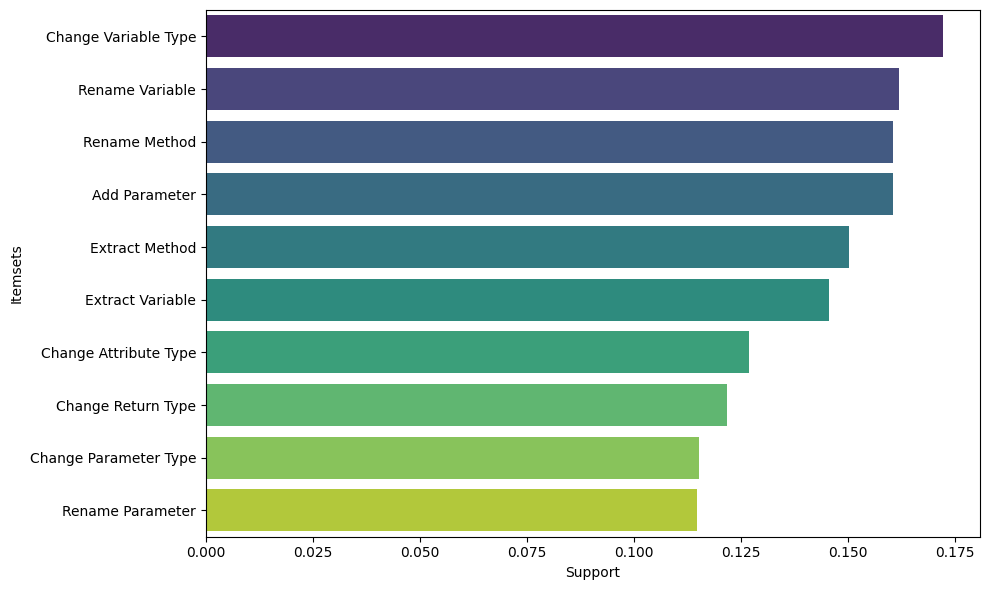

In [16]:
# Visualization of Frequent Itemsets
frequent_itemsets_plot = frequent_itemsets.sort_values(
    by="support", ascending=False
).head(10)

# Modified line to remove 'frozenset()' and extract contents
frequent_itemsets_plot["itemsets"] = frequent_itemsets_plot["itemsets"].apply(
    lambda x: ", ".join(list(x)).replace("'", "")
)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="support",
    y="itemsets",
    data=frequent_itemsets_plot,  # Use the modified dataframe
    palette="viridis",
)
plt.title("")
plt.xlabel("Support")
plt.ylabel("Itemsets")
plt.tight_layout()  # Added to prevent label cutoff
plt.show()

/Users/nanaquam/.pyenv/versions/3.11.0/lib/python3.11/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/nanaquam/.pyenv/versions/3.11.0/lib/python3.11/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


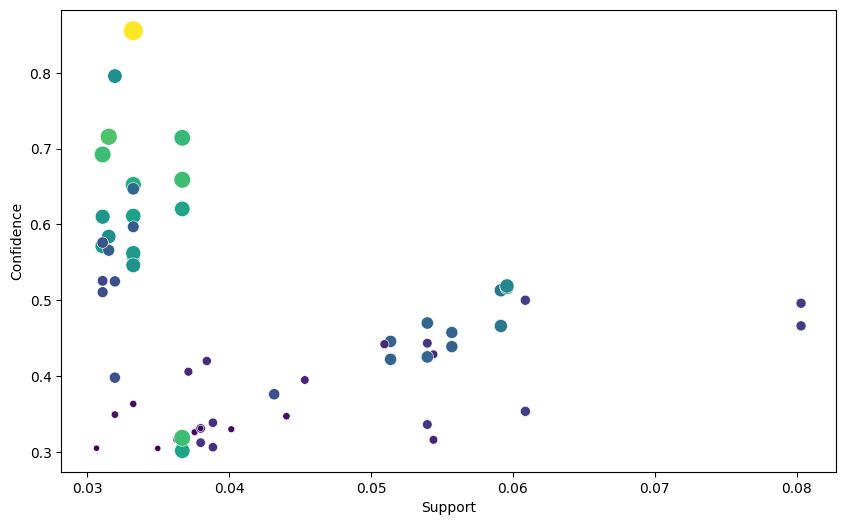

In [17]:
# Visualization of Association Rules
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="support",
    y="confidence",
    size="lift",
    data=rules,
    hue="lift",
    palette="viridis",
    legend=False,
    sizes=(20, 200),
)
plt.title("")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.show()